<a href="https://colab.research.google.com/github/lilyreber/Numerical-inversion-of-characteristic-functions/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from mpmath import *

class ChrFunc:
    def __init__(self, phi):
        self.phi = phi

    def __get_error__(self, true_chr, x):
        error = 0
        for i in range(len(x)):
          error += (cdf(self, x) - true_chr(x)) ** 2
        return error

    def cdf(self, x):
        pass

    def make_plot(self, start, stop, num):
        x = np.linspace(start, stop, num)
        F_x = np.array([self.cdf(y).real for y in x])

        plt.plot(x, F_x, label='Функция распределения')
        plt.title('График функции распределения')
        plt.xlabel('x')
        plt.ylabel('F(x)')
        plt.grid()
        plt.legend()
        plt.show()


import scipy.stats as stats

# Straight on
class A(ChrFunc):
    def __init__(self, N, delta, phi):
        super().__init__(phi)
        self.N = int(N)
        self.delta = delta

    def cdf(self, x):
        F = 0.5 + (self.delta * x) / (2 * pi)
        for v in range(1 - self.N, self.N):
            if v == 0:
                continue
            F -= (self.phi(self.delta * v) / (2 * pi * 1j * v)) * exp(-1j * self.delta * v * x)
        return F


# Battling the truncation error by deforming F
class B(ChrFunc):
    def __init__(self, N, delta, phi):
        super().__init__(phi)
        self.N = int(N)
        self.delta = delta

    def __C(self, t):
        if t > 1:
            return 0
        if t < 0:
            return self.__C(-t)
        return (1 - t) * cos(pi * t) + sin(pi * t) / pi

    def cdf(self, x):
        F = 0.5 + (self.delta * x) / (2 * pi)
        for v in range(1 - self.N, self.N):
            if v == 0:
                continue
            F -= self.__C(v / self.N) * (self.phi(self.delta * v) / (2 * pi * 1j * v)) * exp(-1j * self.delta * v * x)
        return F


# Reducing importance of trigonometric series by considering difference between F and <I>
class C(ChrFunc):
    def __init__(self, N, delta, phi):
        super().__init__(phi)
        self.N = int(N)
        self.delta = delta

    def cdf(self, x):
        F = stats.norm.cdf(x, loc=0, scale=1)
        for v in range(1 - self.N, self.N):
            if v == 0:
                continue
            p = self.delta * v
            F += ((exp(- (p ** 2) / 2) - self.phi(p)) / (2 * pi * 1j * v)) * exp(-1j * p * x)
        return F


# Reducing the aliasing error and reducing importance of trigonometric series
class D(ChrFunc):
    def __init__(self, N, delta, phi, K):
        super().__init__(phi)
        self.N = int(N)
        self.delta = delta
        self.K = K

    def __H(self, x, delta):
        H = 0
        for v in range(1 - self.N, self.N):
            if v == 0:
                continue
            p = delta * v
            H += ((exp(- (p ** 2) / 2) - self.phi(p)) / (2 * pi * 1j * v)) * exp(-1j * p * x)
        return H

    def cdf(self, x):
        F = stats.norm.cdf(x, loc=0, scale=1) + self.__H(x, self.delta)
        d = (2 * pi) / (self.N * self.delta)
        for v in range(1, self.K):
            L = self.N // self.K
            delta_1 = self.delta / self.K
            d_1 = self.K * d
            F -= self.__H(x + v * L * d_1, delta_1)
        return F


# Reducing the aliasing error and Reducing importance of trigonometric
# series and Battling the truncation error by deforming F
class E(ChrFunc):
    def __init__(self, N, delta, phi, K):
        super().__init__(phi)
        self.N = int(N)
        self.delta = delta
        self.K = K

    def __C(self, t):
        if t > 1:
            return 0
        if t < 0:
            return self.__C(-t)
        return (1 - t) * cos(pi * t) + sin(pi * t) / pi

    def __G(self, x, delta):
        G = 0
        for v in range(1 - self.N, self.N):
            if v == 0:
                continue
            p = delta * v
            G += self.__C(v / self.N) * ((exp(- (p ** 2) / 2) - self.phi(p)) / (2 * pi * 1j * v)) * exp(-1j * p * x)
        return G

    def cdf(self, x):
        F = stats.norm.cdf(x, loc=0, scale=1) + self.__G(x, self.delta)
        d = (2 * pi) / (self.N * self.delta)
        for v in range(1, self.K):
            L = self.N / self.K
            delta_1 = self.delta / self.K
            d_1 = self.K * d
            F -= self.__G(x + v * L * d_1, delta_1)
        return F


In [47]:
class Norm():
  def __init__(self, m, var):
      self.m = m
      self.var = var

  def chr(self, x):
      return exp(self.m * 1j * x - (self.var * (x ** 2)) / 2)

  def cdf(self, x):
      return stats.norm.cdf(x, loc=self.m, scale=self.var)


# Проверим на равномерном распределении:

In [36]:
class Unif():
  def __init__(self, a, b):
      self.a = a
      self.b = b

  def chr(self, x):
      return (exp(1j * x * self.b) - exp(1j * x * self.a)) / (1j * x * (self.b - self.a))

  def cdf(self, x):
      if x < self.a:
        return 0
      if x >= self.b:
        return 1
      return (x - self.a) / (self.b - self.a)

In [37]:
unif = Unif(0, 1)

In [38]:
chr = unif.chr

N = 1e3
delta = 1e-1

In [48]:
def make_plot(cdf, start, stop, num):
        x = np.linspace(start, stop, num)
        F_x = np.array([cdf(y).real for y in x])

        plt.plot(x, F_x, label='Функция распределения')
        plt.title('График функции распределения')
        plt.xlabel('x')
        plt.ylabel('F(x)')
        plt.grid()
        plt.legend()
        plt.show()

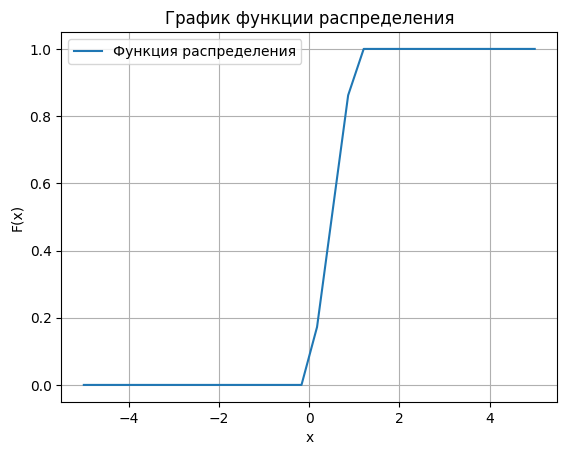

In [49]:
make_plot(unif.cdf, -5, 5, 30)

[mpf('0.007961068557961028'), mpf('0.007956539419996491'), mpf('0.0079541089700510704'), mpf('0.0079589897591651072'), mpf('0.0079617606444350297'), mpf('0.0079564449890874907'), mpf('0.0079532796446522801'), mpf('0.0079591473898746167'), mpf('0.0079627778526917166'), mpf('0.0079561871456349676'), mpf('0.0079519960567597039'), mpf('0.0079595695850174734'), mpf('0.0079644560362902538'), mpf('0.0079554825999842323'), mpf('0.0079496992886810107'), mpf('0.0079607913139447869'), mpf('0.0079677994191765158'), mpf('0.0079532229169603976'), mpf('0.0079443806745381519'), mpf('0.0079654450680350826'), mpf('0.0079775463216859074'), mpf('0.0079415398693311792'), mpf('0.007920882599116141'), mpf('0.0080137791766645289'), mpf('0.0081205015698962955'), mpf('0.11020117245513489'), mpf('0.31416987244738676'), mpf('0.51805872662387242'), mpf('0.72218526459572752'), mpf('0.92671680743502804'), mpf('1.0078621888619261'), mpf('1.0080328239424365'), mpf('1.0079645086815336'), mpf('1.0079283346101455'), mpf(

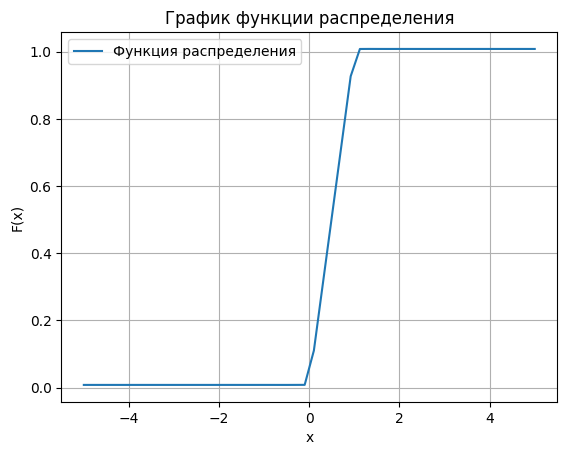

In [41]:
chr_a = A(N, delta, chr)
chr_a.make_plot(-5, 5, 50)

[mpf('0.0079577599496840883'), mpf('0.0079577615063517858'), mpf('0.0079577633254757189'), mpf('0.0079577654679067293'), mpf('0.0079577680096358499'), mpf('0.0079577710442467822'), mpf('0.0079577746970426935'), mpf('0.0079577791416510155'), mpf('0.0079577846074700507'), mpf('0.0079577913959824054'), mpf('0.0079577999337539541'), mpf('0.0079578108483635383'), mpf('0.0079578250408304015'), mpf('0.0079578438147431957'), mpf('0.0079578691959155019'), mpf('0.0079579045040803747'), mpf('0.0079579552308623337'), mpf('0.0079580307852058184'), mpf('0.0079581488282194877'), mpf('0.0079583459970839644'), mpf('0.0079587057261251114'), mpf('0.0079594470461795564'), mpf('0.0079613124552997076'), mpf('0.0079683444699117281'), mpf('0.008069182655309301'), mpf('0.1101095622327941'), mpf('0.31408923244847425'), mpf('0.51816147862181394'), mpf('0.72223250229679692'), mpf('0.92616109976358774'), mpf('1.0078874382699858'), mpf('1.0079484957198512'), mpf('1.007954460123335'), mpf('1.0079561521201541'), mpf(

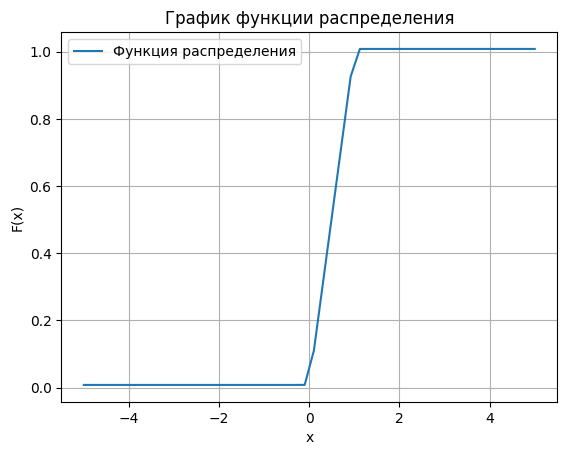

In [42]:
chr_b = B(N, delta, chr)
chr_b.make_plot(-5, 5, 50)

[mpf('0.0079610685579623187'), mpf('0.0079565394199962863'), mpf('0.0079541089700518701'), mpf('0.0079589897591653084'), mpf('0.0079617606444346758'), mpf('0.0079564449890887293'), mpf('0.007953279644652176'), mpf('0.0079591473898737372'), mpf('0.0079627778526914252'), mpf('0.0079561871456358506'), mpf('0.0079519960567605331'), mpf('0.0079595695850172461'), mpf('0.0079644560362903023'), mpf('0.0079554825999838021'), mpf('0.0079496992886806395'), mpf('0.0079607913139444174'), mpf('0.0079677994191761584'), mpf('0.0079532229169607723'), mpf('0.0079443806745381988'), mpf('0.0079654450680349421'), mpf('0.0079775463216861606'), mpf('0.0079415398693311375'), mpf('0.0079208825991160681'), mpf('0.0080137791766643381'), mpf('0.0081205015698975445'), mpf('0.11020117245513425'), mpf('0.31416987244738681'), mpf('0.51805872662387176'), mpf('0.72218526459572774'), mpf('0.92671680743502827'), mpf('1.0078621888619266'), mpf('1.0080328239424363'), mpf('1.007964508681535'), mpf('1.0079283346101473'), mpf

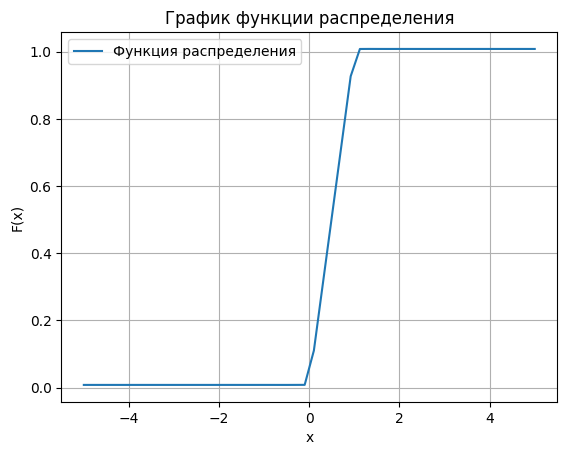

In [43]:
chr_c = C(N, delta, chr)
chr_c.make_plot(-5, 5, 50)

[mpf('0.00052205673950173677'), mpf('0.00093846218599763975'), mpf('0.00093963595027555884'), mpf('0.00052064713438771944'), mpf('0.00090080360181740075'), mpf('0.00097986368481942782'), mpf('0.00052371099238725748'), mpf('0.00085243398707623779'), mpf('0.0010185775446357615'), mpf('0.00054322542230179991'), mpf('0.00079798538759287367'), mpf('0.0010413087414474689'), mpf('0.00057543742483343106'), mpf('0.00075401124031965932'), mpf('0.0010501926881653261'), mpf('0.00060234484808940371'), mpf('0.00072008392360401732'), mpf('0.0010647496627335853'), mpf('0.00062223835159453723'), mpf('0.00067404511769397031'), mpf('0.0010920728451422332'), mpf('0.00066037258348291357'), mpf('0.00058962589183492251'), mpf('0.0011231909160399646'), mpf('0.00088378546989967245'), mpf('0.10283504349750949'), mpf('0.30726620765146317'), mpf('0.51086864364393669'), mpf('0.71479026056428041'), mpf('0.91979248648712397'), mpf('1.0007195642165678'), mpf('1.0006157817002899'), mpf('1.0010125524675693'), mpf('1.00

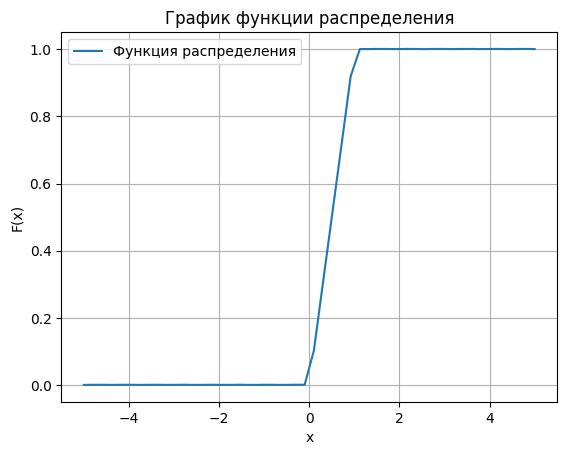

In [44]:
chr_d = D(N, delta, chr, 10)
chr_d.make_plot(-5, 5, 50)

[mpf('0.00079576138007335254'), mpf('0.00079575289491463723'), mpf('0.00079573511179463171'), mpf('0.00079569723682969013'), mpf('0.00079561736608084596'), mpf('0.00079545371983536927'), mpf('0.00079513046429786742'), mpf('0.00079451804094435991'), mpf('0.00079340951197480101'), mpf('0.00079149721353706005'), mpf('0.00078836044778259604'), mpf('0.00078348032436413475'), mpf('0.0007762999235589493'), mpf('0.00076634567486790633'), mpf('0.00075341214959201582'), mpf('0.00073778616744096651'), mpf('0.00072045542636729938'), mpf('0.00070322112771826291'), mpf('0.00068862887969416229'), mpf('0.00067966490487850401'), mpf('0.00067923900013033465'), mpf('0.00068959617817020266'), mpf('0.00071207115279111948'), mpf('0.0007494804680051088'), mpf('0.00088744324698833562'), mpf('0.10296735765262033'), mpf('0.30698415241324656'), mpf('0.51108677593180085'), mpf('0.71517840918150621'), mpf('0.91911662245476566'), mpf('1.0008421753668988'), mpf('1.0008940716913621'), mpf('1.0008853257506269'), mpf('

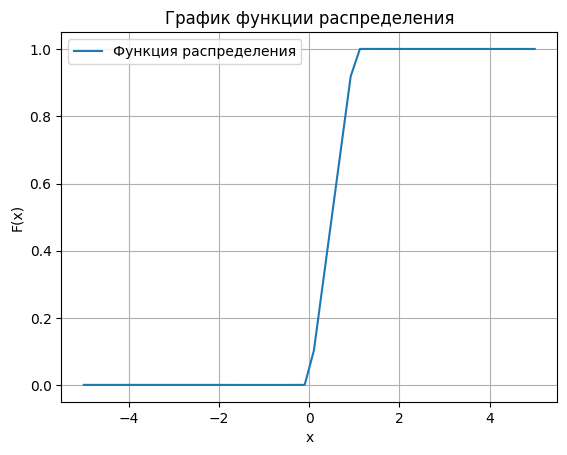

In [45]:
chr_e = E(N, delta, chr, 10)
chr_e.make_plot(-5, 5, 50)

# Провалидируем классы на рассчётах описанных в статье Бохмана.

In [ ]:
from mpmath import mp

In [ ]:
phi = lambda t : ((1 - 1j * t * sqrt(2)) ** (-0.5)) * exp((-1j * t) / sqrt(2))
N = 512
K = 4
d = 0.35 / 16
delta = (2 * pi) / (N * d)

In [ ]:
F_exact = {
    -5.60 : 0,
    -4.55 : 0,
    -3.50 : 0,
    -2.45 : 0,
    -1.40 : 0,
    -1.05 : 0,
    -0.70 : 79586,
    -0.35 : 522700,
    0 : 682690,
    0.35 : 778553,
    0.70 : 841654,
    1.40 : 915695,
    1.75 : 937693,
    2.10 : 953678,
    3.15 : 980485,
    4.20 : 991570,
    5.25 : 996298
}
xs = F_exact.keys()

In [ ]:
approxs = {
    'A' : A(N, delta, phi),
    'B' : B(N, delta, phi),
    'C' : C(N, delta, phi),
    'D' : D(N, delta, phi, K),
    'E' : E(N, delta, phi, K)
}

In [ ]:
values = []

for name in approxs:
  approx_func = approxs[name]
  values.append([(approx_func.cdf(x).real * 1e6 - F_exact[x]) for x in xs])

values = np.array(values)


array([[mpf('-2835.6557302544452'), mpf('-1269.5157399394418'),
        mpf('-574.60516745452469'), mpf('-260.97346261114222'),
        mpf('-106.93877761549368'), mpf('-56.835251529290289'),
        mpf('-4123.270735977494'), mpf('-117.33553835598286'),
        mpf('-80.103089482174255'), mpf('-61.057529963203706'),
        mpf('-50.572631704271771'), mpf('-35.741209859144874'),
        mpf('-32.067856270703487'), mpf('-27.953954378608614'),
        mpf('-21.113144348491915'), mpf('-17.787240787991323'),
        mpf('-14.791953039821237')],
       [mpf('-2822.0218915324617'), mpf('-1257.417101170957'),
        mpf('-564.68639699687571'), mpf('-255.15063682993318'),
        mpf('-115.76078106156453'), mpf('-88.472087398096747'),
        mpf('-8451.4769495937508'), mpf('-130.9534186712699'),
        mpf('-70.163900483748876'), mpf('-45.994061670964584'),
        mpf('-33.737768919207156'), mpf('-18.076166681130417'),
        mpf('-14.473948836908676'), mpf('-10.563881858834065'),
      

In [ ]:
column_names = ["A", "B", "C", "D", "E"]
res = pd.DataFrame(values.transpose(), index=xs, columns=column_names)
res

,A,B,C,D,E
-5.60,-2835.65573025445,-2822.02189153246,-2835.64501266417,20.7863329402116,1.53567873429544
-4.55,-1269.51573993944,-1257.41710117096,-1269.51572528469,6.8485707907399,0.66531766505544
-3.50,-574.605167454525,-564.686396996876,-574.605167447802,-4.24582434746905,0.111001697344409
-2.45,-260.973462611142,-255.150636829933,-260.973462610991,-12.1003603206885,-2.77148666806533
-1.40,-106.938777615494,-115.760781061565,-106.938777615678,-8.58760448309413,-12.3400570009133
-1.05,-56.8352515292903,-88.4720873980967,-56.8352515286242,11.1278816840221,-13.6753212556794
-0.70,-4123.27073597749,-8451.47694959375,-4123.27073597835,-4079.48850378684,-8395.85705634723
-0.35,-117.335538355983,-130.95341867127,-117.335538355866,-92.9850795356324,-85.920671378728
0.00,-80.1030894821743,-70.1639004837489,-80.1030894821743,-71.5548568031518,-29.4466751643922
0.35,-61.0575299632037,-45.9940616709646,-61.057529963553,-65.5433969954029,-6.79181993019301
